<a href="https://colab.research.google.com/github/amara929/amara929/blob/main/Vivian_Ingaitsa_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to CNN Keras - Acc 0.997 (top 8%)

# 1. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a single CPU (i5 2500k). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster !!!

For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.

This Notebook follows three main parts:

The data preparation
The CNN modeling and evaluation
The results prediction and submission

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.

# 2. Data preparation

# 2.1 Load data

In [ ]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

This code loads training and testing datasets into pandas DataFrames:

# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

Explanation:

pd.read_csv(...): This function from the pandas library reads a CSV (Comma-Separated Values) file and loads it into a DataFrame (a 2D tabular data structure with rows and columns).

"/content/train.csv" and "/content/test.csv": These are file paths to the CSV files. This suggests you're likely working in Google Colab, where files are typically accessed via /content/.

train: A DataFrame containing your training data, which includes input features and target labels for training the model.

test: A DataFrame with your testing data, which likely includes only input features (no labels) and is used for model predictions.

,count
label,
1,4684
7,4401
3,4351
9,4188
2,4177
6,4137
0,4132
4,4072
8,4063


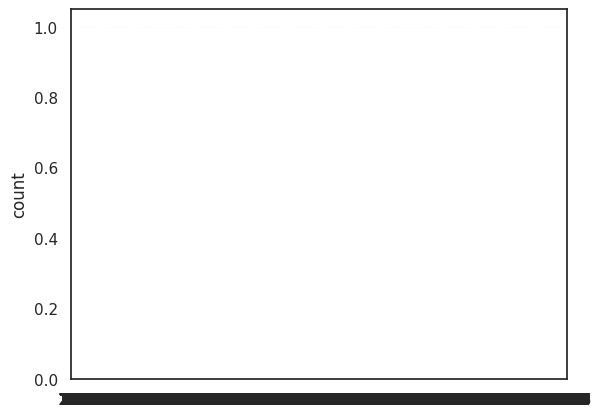

In [ ]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

Here's a breakdown of what each line of the code is doing:

Y_train = train["label"]

This line extracts the label column from the train DataFrame and assigns it to the variable Y_train.

Y_train now contains the target variable (usually the output you want to predict).


X_train = train.drop(labels = ["label"], axis = 1)

This line drops the label column from train and assigns the result to X_train.

X_train contains all the input features (independent variables) without the target column.


del train

This deletes the original train DataFrame from memory to free up space, which is helpful if you're working with large datasets.


g = sns.countplot(Y_train)

This uses Seaborn (sns) to create a count plot of Y_train, showing the number of instances for each label class.

Helps visualize if the dataset is balanced or imbalanced.


Y_train.value_counts()

This line shows the count of each unique value in the Y_train series, which helps to verify class distribution numerically.


Let me know if you want a visual example or how this fits into a specific ML pipeline.

We have similar counts for the 10 digits.

# 2.2 Check for null and missing values

In [ ]:
# Check the data
X_train.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


The line of code:

X_train.isnull().any().describe()

does the following step by step:


---

1. X_train.isnull()

Checks for missing (null) values in the DataFrame X_train.

Returns a DataFrame of the same shape with True for missing values and False otherwise.



---

2. .any()

This is applied column-wise by default.

It returns a Series indicating whether each column contains any True (i.e., at least one missing value).


So at this point, you get a Series like:

feature1    False
feature2     True
...
dtype: bool


---

3. .describe()

Called on the boolean Series from the .any() step.

It returns summary statistics of the Series — things like count, unique, top, and freq if it's categorical (which boolean is treated as in Pandas).


Sample output might be:

count     20
unique     2
top     False
freq      18
dtype: object


---

Summary:

This one-liner checks whether any columns in X_train have missing values and gives you a descriptive summary of how many columns do or don’t have them.

In [ ]:
test.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


The code test.isnull().any().describe() is used in a pandas DataFrame (test) to understand the presence and distribution of missing values (nulls) across its columns. First, test.isnull() returns a DataFrame of the same shape as test, with True where values are NaN (null) and False elsewhere. Then, .any() is called along the default axis (columns), producing a Series indicating which columns contain at least one null value. Finally, .describe() provides summary statistics of this boolean Series, such as the count of columns checked, number of True/False values (freq), and the proportion (top, unique, etc.), helping to quickly understand how widespread nulls are across the dataset.

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

# 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

The code X_train = X_train / 255.0 and test = test / 255.0 is used to normalize the pixel values of image data in the training (X_train) and test (test) datasets. In many image datasets, pixel values range from 0 to 255, where 0 represents black and 255 represents white (or the maximum intensity for a color channel). By dividing each pixel value by 255.0, the data is scaled to a range between 0 and 1. This normalization helps improve the performance and convergence speed of machine learning models, especially neural networks, by ensuring that the input values are within a consistent and manageable range.

# 2.3 Reshape

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

# 2.5 Label encoding

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)


Y_train = to_categorical(Y_train, num_classes=10)

Context

This is often used in classification tasks (e.g., image classification with digits 0–9 in MNIST) where your labels are integers, like:

Y_train = [2, 0, 1, 9, 4]

Each number represents a class.

Purpose

The to_categorical function (usually from keras.utils) converts class labels (integers) into one-hot encoded vectors.

What is One-Hot Encoding?

It's a way to represent categorical values as binary vectors:

The index corresponding to the class is marked as 1

All others are 0


Example (with num_classes=10):

2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

9 → [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Why Use It?

Neural networks (like in Keras) often need labels in one-hot form to compute loss (e.g., categorical crossentropy).

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

# 2.6 Split training and valdiation set

In [ ]:
# Set the random seed
random_seed = 2


random_seed = 2

Explanation:

This line sets a variable named random_seed to the value 2.

It doesn't actually set the seed yet—it's just storing the value. You'd typically pass this variable to a function that sets the random seed for reproducibility.

For example, you might later see:

import numpy as np
import tensorflow as tf
import random

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Why Set a Seed?

Setting a random seed ensures that random operations (like weight initialization, shuffling, etc.) produce the same results every time you run the code. This is super useful for:

Debugging

Comparing experiments

Reproducibility


So in short:
random_seed = 2 just stores the seed value 2 so it can be used later to make your code's randomness consistent.

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

We can get a better sense for one of these examples by visualising the image and looking at the label.

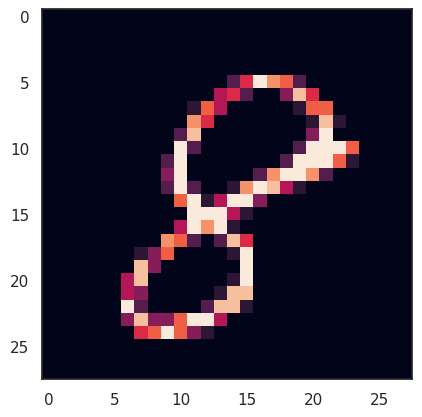

In [ ]:
# Some examples
g = plt.imshow(X_train[0].reshape(28, 28)) #X_train is a numpy array, use array indexing

This line of code is displaying an image using matplotlib. Let's break it down:

g = plt.imshow(X_train.iloc[0].values.reshape(28, 28))

Explanation:

1. X_train:

This is likely a pandas DataFrame that holds your training data.

It contains images represented as flattened arrays (e.g., 784 pixel values for 28x28 images in the MNIST dataset).



2. X_train.iloc[0]:

.iloc[0] is accessing the first row of the X_train DataFrame.

This first row represents the pixel values of the first image in your training set, likely a 1D array of length 784 (28 x 28 pixels).



3. .values:

.values converts the row of the DataFrame to a NumPy array. It is necessary because imshow requires the image data to be in a NumPy array format.



4. .reshape(28, 28):

This reshapes the 1D array of 784 values into a 2D array of shape (28, 28), which corresponds to the dimensions of the image (28x28 pixels). This is required because imshow needs a 2D array to display the image.



5. plt.imshow(...):

imshow is a function from matplotlib used to display an image. It takes the reshaped image and renders it as a visual image on the screen.

g stores the image object that is returned by imshow, though you don't necessarily need to keep it unless you want to manipulate the image later.




In summary:

This code takes the first image from the X_train DataFrame, reshapes it into a 28x28 array, and then displays it as an image using matplotlib.

# 3. CNN

# 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

# 3.3 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation i obtained an accuracy of 98.114%
With data augmentation i achieved 99.67% of accuracy

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
#          validation_data = (X_val, Y_val), verbose = 2)

In [ ]:
# Reshape X_train before calling datagen.fit
# X_train is already a NumPy array, so remove .values
X_train = X_train.reshape(-1, 28, 28, 1)

# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)

datagen.fit(X_train)

Let's break this code down step by step.

1. Reshaping X_train:

X_train = X_train.values.reshape(-1, 28, 28, 1)

X_train.values:

This converts the X_train DataFrame into a NumPy array.


.reshape(-1, 28, 28, 1):

This reshapes the X_train array to a 4D shape of (-1, 28, 28, 1):

-1 means "infer this dimension based on the other dimensions" (it calculates how many images are there).

28 and 28 are the image dimensions (28x28 pixels).

1 is the number of color channels. Since these are grayscale images (like MNIST), it has just 1 channel. For RGB images, this would be 3 (for red, green, and blue).



After reshaping, X_train will have the shape (number_of_samples, 28, 28, 1).


2. Creating the ImageDataGenerator:

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)

Here, you are defining the data augmentation pipeline using ImageDataGenerator. This is used to augment (or modify) the images during training, which helps prevent overfitting by creating slightly different variations of the images for each epoch.

featurewise_center=False:

This means you are not centering the dataset by subtracting the mean of the whole dataset (i.e., each image's mean is not set to zero).


samplewise_center=False:

This means you are not centering each individual sample (image) by subtracting its mean.


featurewise_std_normalization=False:

This means you are not dividing by the standard deviation of the entire dataset.


samplewise_std_normalization=False:

This means you are not dividing each sample (image) by its standard deviation.


zca_whitening=False:

This means you are not applying ZCA whitening (a preprocessing technique to reduce correlations in the image pixels).


rotation_range=10:

This will randomly rotate the images by up to 10 degrees in any direction.


zoom_range=0.1:

This will randomly zoom in on the image by a factor of up to 10%.


width_shift_range=0.1:

This will randomly shift the image horizontally by up to 10% of the image width.


height_shift_range=0.1:

This will randomly shift the image vertically by up to 10% of the image height.


horizontal_flip=False:

This means the images will not be flipped horizontally. If set to True, it would flip some images horizontally.


vertical_flip=False:

This means the images will not be flipped vertically. If set to True, it would flip some images vertically.



3. Fitting the ImageDataGenerator:

datagen.fit(X_train)

This line fits the ImageDataGenerator to the training data (X_train). This means it computes any necessary statistics (e.g., mean, standard deviation) that might be required for normalization or transformations based on your settings (although in this case, you set all the normalization options to False, so no stats are computed).

Once fit, you can use datagen to augment your training images during training by calling it within a model's fit or fit_generator method.


Summary:

Reshaping: You reshape X_train to the proper format for input into a deep learning model, ensuring the images are in a 4D array with the shape (samples, 28, 28, 1).

Data Augmentation: You create an ImageDataGenerator to perform random transformations (rotation, zoom, shift) on your images to artificially expand the training dataset and prevent overfitting.

Fitting the Augmentor: You "fit" the generator to your data, which prepares it to apply augmentations during training.

For the data augmentation, i chose to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# 4. Evaluate the model

# 4.1 Training and validation curves

In [ ]:
# Assuming you have already defined and compiled your model as in your previous code

# Set the number of epochs and batch size
epochs = 30  # You can adjust this to your desired number of epochs
batch_size = 86

# Fit the model and store the training history
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),  # Use datagen.flow for data augmentation
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,  # Set verbose to 1 or 2 for progress updates during training
    steps_per_epoch=X_train.shape[0] // batch_size,  # Adjust steps_per_epoch if needed
    callbacks=[learning_rate_reduction]  # Include your learning rate scheduler
)

# Now you can use 'history' to plot the loss and accuracy curves

Epoch 1/30
439/439 - 12s - 26ms/step - accuracy: 0.9853 - loss: 0.0545 - val_accuracy: 0.9924 - val_loss: 0.0236 - learning_rate: 1.0000e-03
Epoch 2/30
439/439 - 1s - 1ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9919 - val_loss: 0.0239 - learning_rate: 1.0000e-03
Epoch 3/30
439/439 - 20s - 45ms/step - accuracy: 0.9847 - loss: 0.0546 - val_accuracy: 0.9952 - val_loss: 0.0202 - learning_rate: 1.0000e-03
Epoch 4/30
439/439 - 0s - 987us/step - accuracy: 0.9884 - loss: 0.0842 - val_accuracy: 0.9955 - val_loss: 0.0191 - learning_rate: 1.0000e-03
Epoch 5/30
439/439 - 20s - 46ms/step - accuracy: 0.9852 - loss: 0.0544 - val_accuracy: 0.9936 - val_loss: 0.0243 - learning_rate: 1.0000e-03
Epoch 6/30
439/439 - 0s - 861us/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9936 - val_loss: 0.0240 - learning_rate: 1.0000e-03
Epoch 7/30
439/439 - 20s - 46ms/step - accuracy: 0.9851 - loss: 0.0572 - val_accuracy: 0.9924 - val_loss: 0.0217 - learning_rate: 1.0000e-03
Epoch 8/30
439/

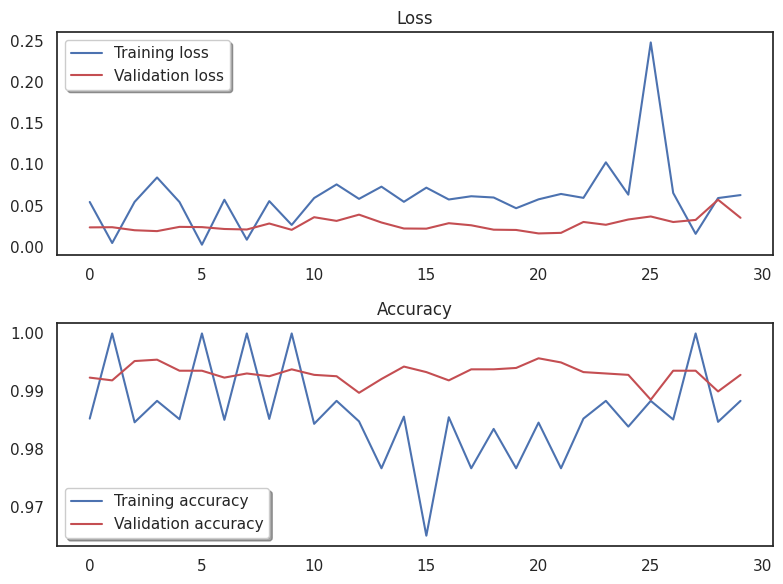

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the history in a variable called 'history'
# For example: history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=2)

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Plot training & validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].set_title('Loss')
ax[0].legend(loc='best', shadow=True)

# Plot training & validation accuracy
ax[1].plot(history.history.get('accuracy', history.history.get('acc', [])), color='b', label="Training accuracy")
ax[1].plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), color='r', label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].legend(loc='best', shadow=True)

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [ ]:
# Import necessary modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)


datagen.fit(X_train)

# Set the number of epochs and batch size
epochs = 30  # You can adjust this to your desired number of epochs
batch_size = 86

# Fit the model and store the training history
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),  # Use datagen.flow for data augmentation
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,  # Set verbose to 1 or 2 for progress updates during training
    steps_per_epoch=X_train.shape[0] // batch_size,  # Adjust steps_per_epoch if needed
    callbacks=[learning_rate_reduction]  # Include your learning rate scheduler
)

# Now you can use 'history' to plot the loss and accuracy curves

Epoch 1/30
439/439 - 12s - 27ms/step - accuracy: 0.9840 - loss: 0.0630 - val_accuracy: 0.9924 - val_loss: 0.0397 - learning_rate: 1.0000e-03
Epoch 2/30
439/439 - 0s - 845us/step - accuracy: 0.9767 - loss: 0.1382 - val_accuracy: 0.9907 - val_loss: 0.0390 - learning_rate: 1.0000e-03
Epoch 3/30
439/439 - 12s - 27ms/step - accuracy: 0.9842 - loss: 0.0660 - val_accuracy: 0.9940 - val_loss: 0.0211 - learning_rate: 1.0000e-03
Epoch 4/30
439/439 - 1s - 1ms/step - accuracy: 0.9884 - loss: 0.0581 - val_accuracy: 0.9943 - val_loss: 0.0222 - learning_rate: 1.0000e-03
Epoch 5/30
439/439 - 20s - 45ms/step - accuracy: 0.9836 - loss: 0.0677 - val_accuracy: 0.9919 - val_loss: 0.0362 - learning_rate: 1.0000e-03
Epoch 6/30
439/439 - 1s - 1ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9907 - val_loss: 0.0497 - learning_rate: 1.0000e-03
Epoch 7/30
439/439 - 12s - 27ms/step - accuracy: 0.9846 - loss: 0.0657 - val_accuracy: 0.9919 - val_loss: 0.0301 - learning_rate: 1.0000e-03
Epoch 8/30
439/43

The code below is for plotting loss and accuracy curves for training and validation. Since, i set epochs = 2 on this notebook . I'll show you the training and validation curves i obtained from the model i build with 30 epochs (2h30)



The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model dosen't not overfit the training set.

Our model is very well trained !!!

# 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


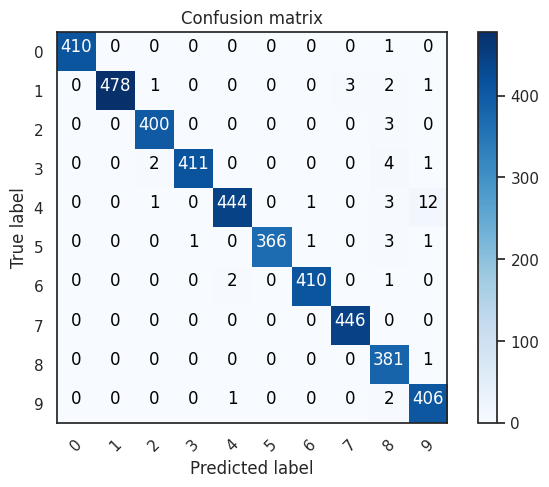

In [ ]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

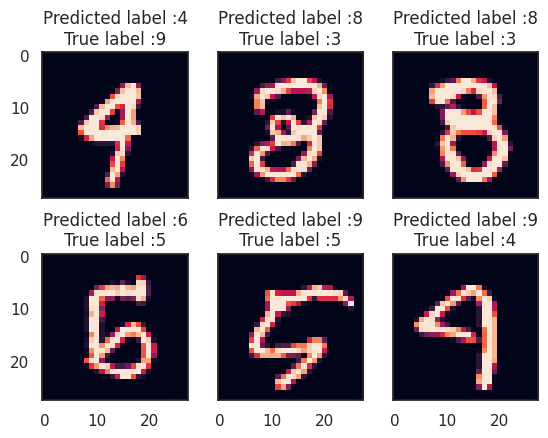

In [ ]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
